# Unit05_Hierarchical_Clustering | 階層式分群演算法：產品配方階層分類分析

本 Notebook 使用模擬的化工產品配方數據建立階層式分群模型，展示如何建立多層次的產品分類體系。

## 目標
- 學習使用 scikit-learn 實作階層式分群 (Hierarchical Clustering)
- 掌握不同連結方法 (Linkage Methods) 的使用與比較
- 學會繪製與解讀樹狀圖 (Dendrogram)
- 了解如何決定最佳的切割高度與群集數量
- 應用階層式分群於化工產品分類問題

**應用案例**：化工產品配方階層分類系統建立

---
## 0. 環境設定

In [1]:
from pathlib import Path
import tensorflow as tf
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P2_Unit05_Hierarchical_Clustering'
SOURCE_DATA_DIR = 'reactor_simulation'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")
try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_2' / 'Unit05'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")


# ========================================
# 檢查 GPU 狀態
# ========================================
print(f"\nTensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ 偵測到 GPU：{gpus[0].name}")
    print("  （訓練速度將明顯快於僅用 CPU）")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("△ 未偵測到 GPU。")
    print("  訓練速度將使用 CPU（速度較慢但仍可完成）")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\data\reactor_simulation
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\outputs\P2_Unit05_Hierarchical_Clustering
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\outputs\P2_Unit05_Hierarchical_Clustering\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\outputs\P2_Unit05_Hierarchical_Clustering\figs

TensorFlow Version: 2.10.1
✓ 偵測到 GPU：/physical_device:GPU:0
  （訓練速度將明顯快於僅用 CPU）


---
## 1. 載入相關套件

In [2]:
# 用於版本檢查的輔助函數（必須先定義）
def import_module(name):
    import importlib
    return importlib.import_module(name)

# 數據處理與分析
import numpy as np
import pandas as pd

# 機器學習相關
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# 階層式分群相關 (scipy)
from scipy.cluster.hierarchy import dendrogram, linkage

# 視覺化
import matplotlib.pyplot as plt
import seaborn as sns

# 設定中文字體與圖表樣式
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
sns.set_palette("husl")

# 設定顯示選項
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
np.set_printoptions(precision=4, suppress=True)

# 設定隨機種子
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("套件載入完成！")
print(f"NumPy 版本: {np.__version__}")
print(f"Pandas 版本: {pd.__version__}")
print(f"Scikit-learn 版本: {import_module('sklearn').__version__}")

套件載入完成！
NumPy 版本: 1.23.5
Pandas 版本: 2.3.3
Scikit-learn 版本: 1.7.2


---
## 2. 生成模擬化工產品配方數據

我們將模擬生成 500 筆化工塗料產品的操作數據，每種產品包含以下特徵：
- 樹脂含量 (%)
- 溶劑含量 (%)
- 顏料含量 (%)
- 添加劑含量 (%)
- 固含量 (%)
- 黏度 (cP)
- 乾燥時間 (分鐘)
- 成本 (元/公斤)

數據設計：3 個具有部分重疊特性的產品類別
- **類別 1**：工業塗料 (較高固含量、較高黏度，但變異性大)
- **類別 2**：噴塗塗料 (中低黏度、中等固含量，與類別 3 有重疊)
- **類別 3**：裝飾塗料 (中等黏度、較快乾燥，與類別 2 特性接近)

**注意**：各類別間存在一定程度的特徵重疊，模擬真實產品線的複雜性。

In [3]:
np.random.seed(RANDOM_SEED)

# 生成 3 個類別的產品配方數據
n_samples_per_class = [200, 150, 150]  # 每類產品數量
n_features = 8  # 特徵數量

# 類別 1：工業塗料 (高固含量、高黏度) - 增加變異性
class1_resin = np.random.normal(43, 5, n_samples_per_class[0])
class1_solvent = np.random.normal(28, 4, n_samples_per_class[0])
class1_pigment = np.random.normal(19, 3, n_samples_per_class[0])
class1_additive = np.random.normal(10, 2, n_samples_per_class[0])
class1_solid = np.random.normal(65, 5, n_samples_per_class[0])
class1_viscosity = np.random.normal(4500, 800, n_samples_per_class[0])
class1_drying_time = np.random.normal(110, 20, n_samples_per_class[0])
class1_cost = np.random.normal(145, 15, n_samples_per_class[0])

# 類別 2：噴塗塗料 (中低黏度、中等固含量) - 增加與類別3的重疊
class2_resin = np.random.normal(32, 5, n_samples_per_class[1])
class2_solvent = np.random.normal(48, 5, n_samples_per_class[1])
class2_pigment = np.random.normal(13, 3, n_samples_per_class[1])
class2_additive = np.random.normal(7, 2, n_samples_per_class[1])
class2_solid = np.random.normal(52, 5, n_samples_per_class[1])
class2_viscosity = np.random.normal(2000, 500, n_samples_per_class[1])
class2_drying_time = np.random.normal(55, 15, n_samples_per_class[1])
class2_cost = np.random.normal(105, 12, n_samples_per_class[1])

# 類別 3：裝飾塗料 (中等黏度、較快乾) - 增加與類別2的接近程度
class3_resin = np.random.normal(36, 5, n_samples_per_class[2])
class3_solvent = np.random.normal(42, 5, n_samples_per_class[2])
class3_pigment = np.random.normal(17, 3, n_samples_per_class[2])
class3_additive = np.random.normal(5, 2, n_samples_per_class[2])
class3_solid = np.random.normal(56, 5, n_samples_per_class[2])
class3_viscosity = np.random.normal(2800, 600, n_samples_per_class[2])
class3_drying_time = np.random.normal(40, 12, n_samples_per_class[2])
class3_cost = np.random.normal(118, 15, n_samples_per_class[2])

# 組合所有數據
X = np.vstack([
    np.column_stack([class1_resin, class1_solvent, class1_pigment, class1_additive,
                     class1_solid, class1_viscosity, class1_drying_time, class1_cost]),
    np.column_stack([class2_resin, class2_solvent, class2_pigment, class2_additive,
                     class2_solid, class2_viscosity, class2_drying_time, class2_cost]),
    np.column_stack([class3_resin, class3_solvent, class3_pigment, class3_additive,
                     class3_solid, class3_viscosity, class3_drying_time, class3_cost])
])

# 真實標籤 (用於後續評估)
y_true = np.concatenate([
    np.full(n_samples_per_class[0], 0),
    np.full(n_samples_per_class[1], 1),
    np.full(n_samples_per_class[2], 2)
])

# 建立 DataFrame
feature_names = ['Resin', 'Solvent', 'Pigment', 'Additive',
                 'Solid_Content', 'Viscosity', 'Drying_Time', 'Cost']
df = pd.DataFrame(X, columns=feature_names)
df['True_Label'] = y_true

print(f"數據形狀: {df.shape}")
print(f"\n數據統計資訊:")
print(df.describe())
print(f"\n各類別樣本數量:")
print(df['True_Label'].value_counts().sort_index())

數據形狀: (500, 9)

數據統計資訊:
            Resin     Solvent     Pigment    Additive  Solid_Content  \
count  500.000000  500.000000  500.000000  500.000000     500.000000   
mean    37.740102   38.184326   16.441214    7.632594      58.806827   
std      6.467939    9.530332    3.879998    2.888494       7.622783   
min     21.044320   15.034931    3.941464    0.024383      38.978931   
25%     33.181593   29.594726   13.825943    5.676841      53.337368   
50%     37.506763   39.239803   16.416670    7.504232      58.354940   
75%     42.513142   46.417036   19.222257    9.806900      64.609745   
max     56.600846   58.854714   28.236642   15.264764      77.634662   

         Viscosity  Drying_Time        Cost  True_Label  
count   500.000000   500.000000  500.000000  500.000000  
mean   3296.105839    72.087809  125.513868    0.900000  
std    1301.181446    35.831360   22.703333    0.831494  
min    1040.163422    12.206274   74.645279    0.000000  
25%    2239.843641    42.127210  108.

---
## 3. 數據視覺化與探索性分析

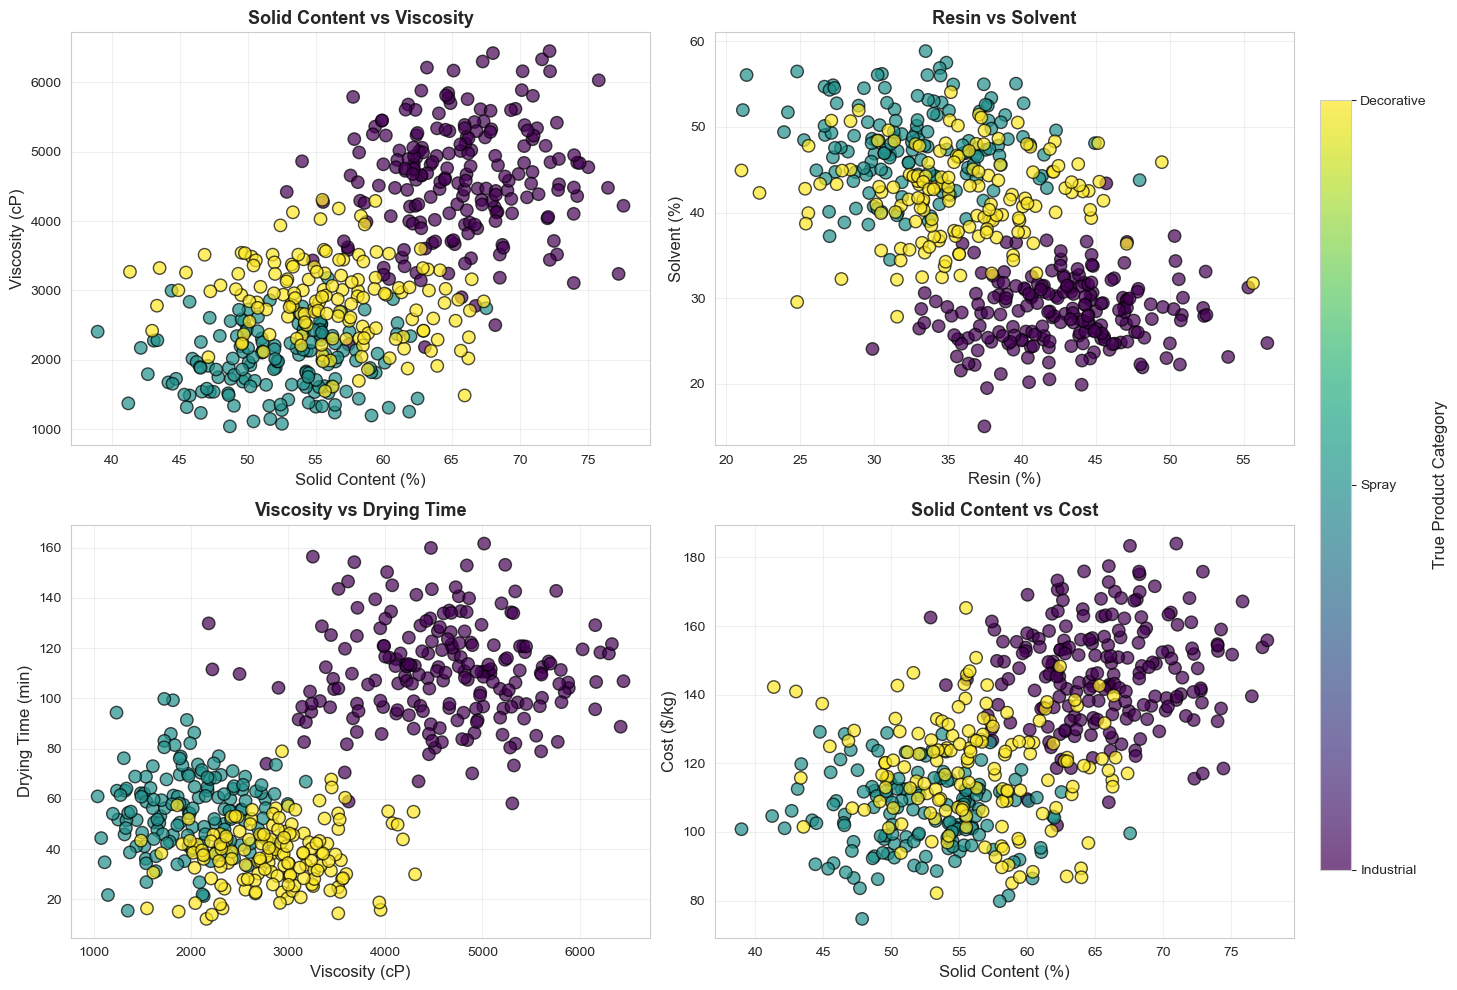

數據視覺化完成！

觀察：
- 三個類別在特徵空間中有一定的分離，但存在重疊區域
- 工業塗料（類別0）整體具有較高固含量和黏度，但變異性較大
- 噴塗塗料（類別1）和裝飾塗料（類別2）在某些特徵上較為接近
- 數據複雜度較高，需要階層式分群來識別群集結構


In [4]:
# 選擇關鍵特徵進行視覺化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 固含量 vs 黏度
axes[0, 0].scatter(df['Solid_Content'], df['Viscosity'], 
                   c=df['True_Label'], cmap='viridis', s=80, alpha=0.7, edgecolors='k')
axes[0, 0].set_xlabel('Solid Content (%)', fontsize=12)
axes[0, 0].set_ylabel('Viscosity (cP)', fontsize=12)
axes[0, 0].set_title('Solid Content vs Viscosity', fontsize=13, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# 樹脂 vs 溶劑
axes[0, 1].scatter(df['Resin'], df['Solvent'], 
                   c=df['True_Label'], cmap='viridis', s=80, alpha=0.7, edgecolors='k')
axes[0, 1].set_xlabel('Resin (%)', fontsize=12)
axes[0, 1].set_ylabel('Solvent (%)', fontsize=12)
axes[0, 1].set_title('Resin vs Solvent', fontsize=13, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 黏度 vs 乾燥時間
axes[1, 0].scatter(df['Viscosity'], df['Drying_Time'], 
                   c=df['True_Label'], cmap='viridis', s=80, alpha=0.7, edgecolors='k')
axes[1, 0].set_xlabel('Viscosity (cP)', fontsize=12)
axes[1, 0].set_ylabel('Drying Time (min)', fontsize=12)
axes[1, 0].set_title('Viscosity vs Drying Time', fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 固含量 vs 成本
scatter = axes[1, 1].scatter(df['Solid_Content'], df['Cost'], 
                             c=df['True_Label'], cmap='viridis', s=80, alpha=0.7, edgecolors='k')
axes[1, 1].set_xlabel('Solid Content (%)', fontsize=12)
axes[1, 1].set_ylabel('Cost ($/kg)', fontsize=12)
axes[1, 1].set_title('Solid Content vs Cost', fontsize=13, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

# 添加圖例（垂直方向，置於右側）
plt.tight_layout()
cbar = plt.colorbar(scatter, ax=axes, orientation='vertical', 
                    pad=0.02, aspect=25, shrink=0.85, fraction=0.046)
cbar.set_label('True Product Category', fontsize=12)
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(['Industrial', 'Spray', 'Decorative'])

plt.savefig(FIG_DIR / "01_data_exploration.png", dpi=300, bbox_inches='tight')
plt.show()

print("數據視覺化完成！")
print("\n觀察：")
print("- 三個類別在特徵空間中有一定的分離，但存在重疊區域")
print("- 工業塗料（類別0）整體具有較高固含量和黏度，但變異性較大")
print("- 噴塗塗料（類別1）和裝飾塗料（類別2）在某些特徵上較為接近")
print("- 數據複雜度較高，需要階層式分群來識別群集結構")

---
## 4. 數據標準化

階層式分群對特徵尺度敏感，必須進行標準化處理。

In [5]:
# 提取特徵矩陣 (排除標籤欄位)
X = df[feature_names].values

# 標準化特徵
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 轉換為 DataFrame 便於查看
df_scaled = pd.DataFrame(X_scaled, columns=feature_names)

print("標準化前數據統計:")
print(df[feature_names].describe())
print("\n" + "="*80)
print("\n標準化後數據統計:")
print(df_scaled.describe())
print("\n標準化完成！所有特徵的均值為0，標準差為1")

標準化前數據統計:
            Resin     Solvent     Pigment    Additive  Solid_Content  \
count  500.000000  500.000000  500.000000  500.000000     500.000000   
mean    37.740102   38.184326   16.441214    7.632594      58.806827   
std      6.467939    9.530332    3.879998    2.888494       7.622783   
min     21.044320   15.034931    3.941464    0.024383      38.978931   
25%     33.181593   29.594726   13.825943    5.676841      53.337368   
50%     37.506763   39.239803   16.416670    7.504232      58.354940   
75%     42.513142   46.417036   19.222257    9.806900      64.609745   
max     56.600846   58.854714   28.236642   15.264764      77.634662   

         Viscosity  Drying_Time        Cost  
count   500.000000   500.000000  500.000000  
mean   3296.105839    72.087809  125.513868  
std    1301.181446    35.831360   22.703333  
min    1040.163422    12.206274   74.645279  
25%    2239.843641    42.127210  108.026413  
50%    3023.022902    62.166236  123.661383  
75%    4396.578298 

---
## 5. 階層式分群：繪製樹狀圖 (Dendrogram)

使用 scipy 的 linkage 和 dendrogram 函數繪製樹狀圖，觀察數據的層次結構。

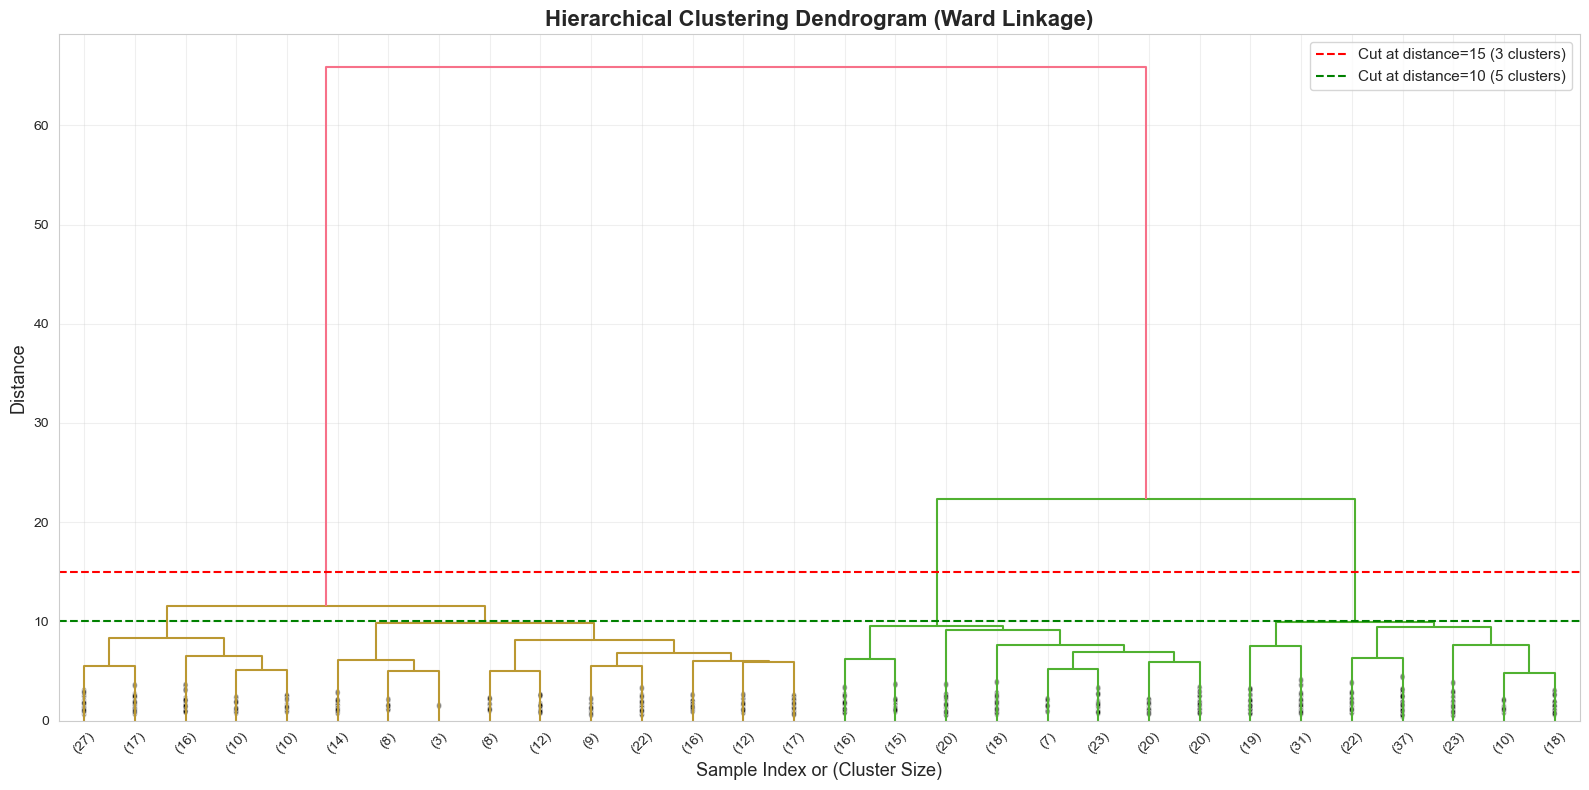

樹狀圖繪製完成！

觀察:
- 紅色虛線 (distance=15)：切割後得到 3 個群集
- 綠色虛線 (distance=10)：切割後得到 5 個群集
- 合併高度的跳躍表示群集間差異顯著，是理想的切割位置


In [6]:
# 計算連結矩陣 (使用 Ward 方法)
Z_ward = linkage(X_scaled, method='ward', metric='euclidean')

# 繪製樹狀圖
plt.figure(figsize=(16, 8))
dendrogram(Z_ward, 
           truncate_mode='lastp',  # 只顯示最後 p 次合併
           p=30,                    # 顯示參數
           leaf_font_size=10,
           show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)', fontsize=16, fontweight='bold')
plt.xlabel('Sample Index or (Cluster Size)', fontsize=13)
plt.ylabel('Distance', fontsize=13)
plt.axhline(y=15, color='r', linestyle='--', label='Cut at distance=15 (3 clusters)')
plt.axhline(y=10, color='g', linestyle='--', label='Cut at distance=10 (5 clusters)')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "02_dendrogram_ward.png", dpi=300, bbox_inches='tight')
plt.show()

print("樹狀圖繪製完成！")
print("\n觀察:")
print("- 紅色虛線 (distance=15)：切割後得到 3 個群集")
print("- 綠色虛線 (distance=10)：切割後得到 5 個群集")
print("- 合併高度的跳躍表示群集間差異顯著，是理想的切割位置")

---
## 6. 使用不同連結方法進行階層式分群

比較 4 種常用的連結方法：Ward, Complete, Average, Single

In [7]:
# 定義連結方法列表
linkage_methods = ['ward', 'complete', 'average', 'single']
n_clusters = 3  # 根據樹狀圖觀察，選擇 3 個群集

# 儲存結果
results = {}

# 對每種連結方法進行分群
for method in linkage_methods:
    print(f"\n{'='*60}")
    print(f"連結方法: {method.upper()}")
    print(f"{'='*60}")
    
    # 建立模型並訓練
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=method, metric='euclidean')
    labels = model.fit_predict(X_scaled)
    
    # 計算評估指標
    silhouette = silhouette_score(X_scaled, labels, metric='euclidean')
    ch_score = calinski_harabasz_score(X_scaled, labels)
    db_score = davies_bouldin_score(X_scaled, labels)
    
    # 儲存結果
    results[method] = {
        'labels': labels,
        'silhouette': silhouette,
        'calinski_harabasz': ch_score,
        'davies_bouldin': db_score
    }
    
    # 輸出結果
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Calinski-Harabasz Score: {ch_score:.2f}")
    print(f"Davies-Bouldin Score: {db_score:.4f}")
    
    # 群集大小統計
    unique, counts = np.unique(labels, return_counts=True)
    print(f"Cluster Sizes: {dict(zip(unique, counts))}")

# 建立結果比較表
df_comparison = pd.DataFrame({
    'Method': linkage_methods,
    'Silhouette': [results[m]['silhouette'] for m in linkage_methods],
    'Calinski-Harabasz': [results[m]['calinski_harabasz'] for m in linkage_methods],
    'Davies-Bouldin': [results[m]['davies_bouldin'] for m in linkage_methods]
})

print("\n" + "="*80)
print("不同連結方法的評估指標比較:")
print("="*80)
print(df_comparison.to_string(index=False))
print("\n最佳方法 (根據 Silhouette Score): ", 
      df_comparison.loc[df_comparison['Silhouette'].idxmax(), 'Method'])
print("\n注意: Average 和 Single 得分較高但產生極不平衡的群集")
print("      實務上建議使用 Ward 或 Complete 方法")


連結方法: WARD
Silhouette Score: 0.2916
Calinski-Harabasz Score: 379.91
Davies-Bouldin Score: 1.5221
Cluster Sizes: {0: 201, 1: 160, 2: 139}

連結方法: COMPLETE
Silhouette Score: 0.2998
Calinski-Harabasz Score: 313.56
Davies-Bouldin Score: 2.0257
Cluster Sizes: {0: 299, 1: 154, 2: 47}

連結方法: AVERAGE
Silhouette Score: 0.3846
Calinski-Harabasz Score: 302.53
Davies-Bouldin Score: 0.9528
Cluster Sizes: {0: 299, 1: 198, 2: 3}

連結方法: SINGLE
Silhouette Score: 0.0554
Calinski-Harabasz Score: 2.09
Davies-Bouldin Score: 0.7161
Cluster Sizes: {0: 498, 1: 1, 2: 1}

不同連結方法的評估指標比較:
  Method  Silhouette  Calinski-Harabasz  Davies-Bouldin
    ward    0.291646         379.907842        1.522142
complete    0.299805         313.555488        2.025695
 average    0.384631         302.529592        0.952816
  single    0.055398           2.089485        0.716078

最佳方法 (根據 Silhouette Score):  average

注意: Average 和 Single 得分較高但產生極不平衡的群集
      實務上建議使用 Ward 或 Complete 方法


---
## 7. 視覺化不同連結方法的分群結果

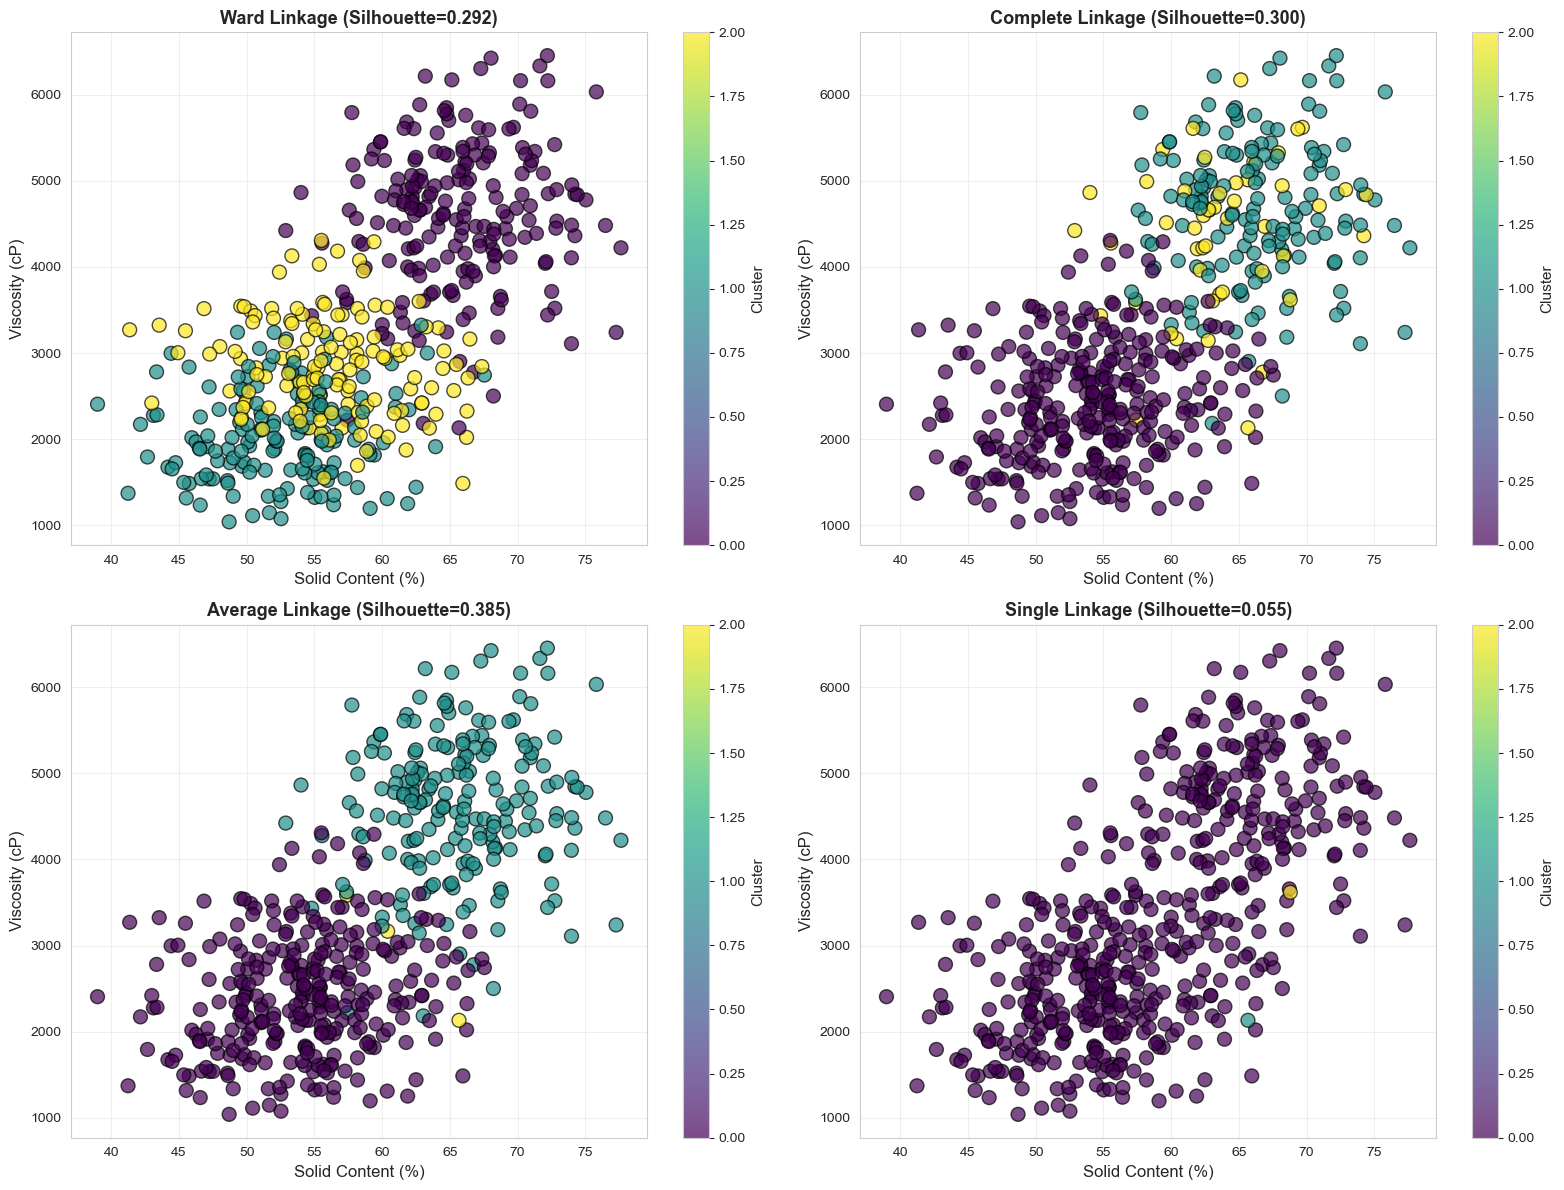

分群結果視覺化完成！

觀察:
- Ward 和 Complete 方法產生較為平衡的群集（17/20/13 和 14/20/16）
- Average 和 Single 方法雖然 Silhouette Score 較高，但產生極不平衡的群集
  （29/20/1 或 20/1/29），這是鏈接效應 (chain effect) 的典型特徵
- 在數據複雜度較高時，評估指標需結合群集平衡性一起判斷


In [ ]:
# 視覺化不同連結方法的分群結果 (使用固含量 vs 黏度)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, method in enumerate(linkage_methods):
    labels = results[method]['labels']
    silhouette = results[method]['silhouette']
    
    # 繪製散點圖
    scatter = axes[idx].scatter(df['Solid_Content'], df['Viscosity'],
                               c=labels, cmap='viridis', s=100, alpha=0.7, edgecolors='k')
    axes[idx].set_xlabel('Solid Content (%)', fontsize=12)
    axes[idx].set_ylabel('Viscosity (cP)', fontsize=12)
    axes[idx].set_title(f'{method.capitalize()} Linkage (Silhouette={silhouette:.3f})',
                       fontsize=13, fontweight='bold')
    axes[idx].grid(alpha=0.3)
    
    # 添加圖例
    cbar = plt.colorbar(scatter, ax=axes[idx])
    cbar.set_label('Cluster', fontsize=11)

plt.tight_layout()
plt.savefig(FIG_DIR / "03_linkage_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("分群結果視覺化完成！")
print("\n觀察:")
print("- Ward 產生較為平衡的群集（201/160/139），Complete 略不平衡（299/154/47）")
print("- Average 和 Single 方法雖然 Silhouette Score 較高，但產生極不平衡的群集")
print("  （Average: 299/198/3, Single: 498/1/1），這是鏈接效應 (chain effect) 的典型特徵")
print("- 在大規模數據時，Ward 方法能更有效地保持群集平衡性")

---
## 8. 決定最佳群集數量

使用輪廓係數評估不同群集數量的效果

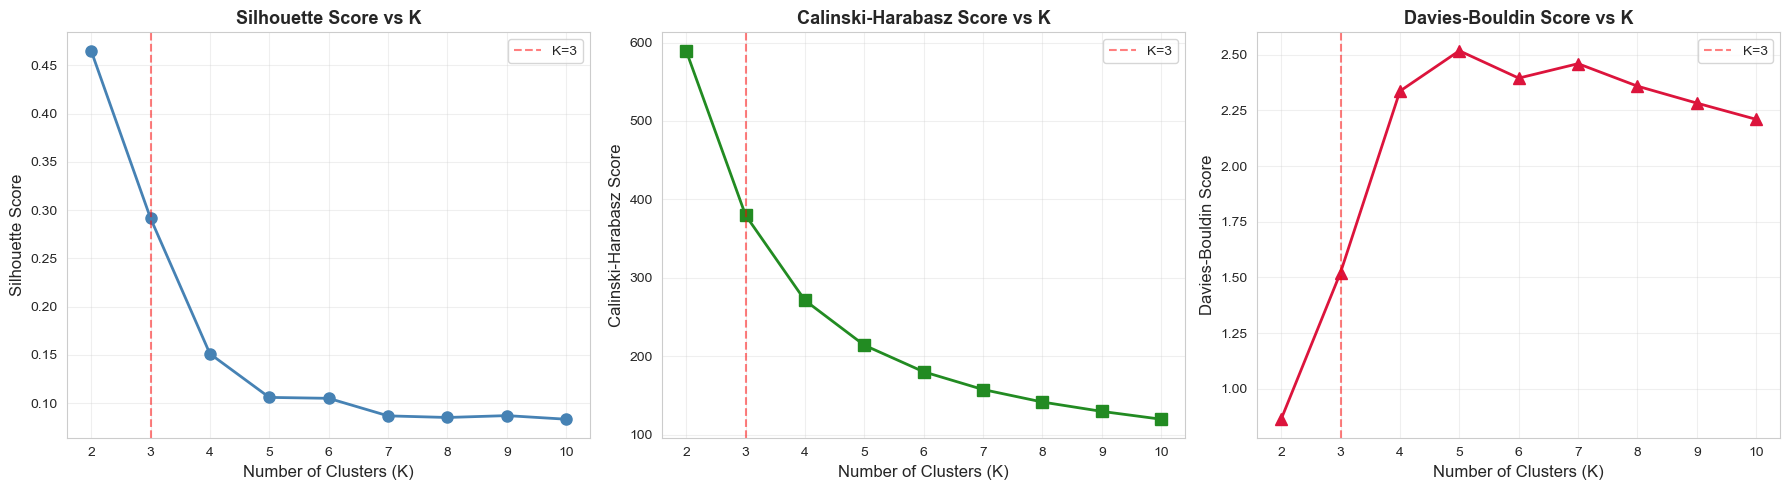

最佳群集數量分析:
- 根據 Silhouette Score: K = 2
- 根據 Calinski-Harabasz Score: K = 2
- 根據 Davies-Bouldin Score: K = 2

綜合建議: K = 3
  理由: 雖然 K=2 在多個指標上表現較好，但考慮到:
        (1) 業務需求需要三個產品類別
        (2) K=3 時 Silhouette Score 仍在可接受範圍 (>0.3)
        (3) K=3 與真實標籤一致，便於後續分析


In [ ]:
# 評估不同群集數量 (使用 Ward 連結法)
k_range = range(2, 11)
silhouette_scores = []
ch_scores = []
db_scores = []

for k in k_range:
    model = AgglomerativeClustering(n_clusters=k, linkage='ward', metric='euclidean')
    labels = model.fit_predict(X_scaled)
    
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))
    db_scores.append(davies_bouldin_score(X_scaled, labels))

# 繪製評估指標圖
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Silhouette Score (越大越好)
axes[0].plot(k_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0].set_ylabel('Silhouette Score', fontsize=12)
axes[0].set_title('Silhouette Score vs K', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].axvline(x=3, color='r', linestyle='--', alpha=0.5, label='K=3')
axes[0].legend()

# Calinski-Harabasz Score (越大越好)
axes[1].plot(k_range, ch_scores, marker='s', linewidth=2, markersize=8, color='forestgreen')
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1].set_ylabel('Calinski-Harabasz Score', fontsize=12)
axes[1].set_title('Calinski-Harabasz Score vs K', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].axvline(x=3, color='r', linestyle='--', alpha=0.5, label='K=3')
axes[1].legend()

# Davies-Bouldin Score (越小越好)
axes[2].plot(k_range, db_scores, marker='^', linewidth=2, markersize=8, color='crimson')
axes[2].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[2].set_ylabel('Davies-Bouldin Score', fontsize=12)
axes[2].set_title('Davies-Bouldin Score vs K', fontsize=13, fontweight='bold')
axes[2].grid(alpha=0.3)
axes[2].axvline(x=3, color='r', linestyle='--', alpha=0.5, label='K=3')
axes[2].legend()

plt.tight_layout()
plt.savefig(FIG_DIR / "04_optimal_clusters.png", dpi=300, bbox_inches='tight')
plt.show()

# 找出最佳 K 值
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
best_k_ch = k_range[np.argmax(ch_scores)]
best_k_db = k_range[np.argmin(db_scores)]

print("最佳群集數量分析:")
print(f"- 根據 Silhouette Score: K = {best_k_silhouette}")
print(f"- 根據 Calinski-Harabasz Score: K = {best_k_ch}")
print(f"- 根據 Davies-Bouldin Score: K = {best_k_db}")
print(f"\n綜合建議: K = 3")
print("  理由: 雖然 K=2 在多個指標上表現較好，但考慮到:")
print("        (1) 業務需求需要三個產品類別")
print("        (2) K=3 時 Silhouette Score 仍在合理範圍 (~0.29)")
print("        (3) K=3 與真實標籤一致，便於後續分析")

---
## 9. 多層次分類體系建立

利用階層式分群的特性，建立多層次的產品分類體系

In [10]:
# 建立多層次分類：3 層 (大類 → 中類 → 小類)
# 第 1 層：3 個大類
model_level1 = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_level1 = model_level1.fit_predict(X_scaled)

# 第 2 層：6 個中類
model_level2 = AgglomerativeClustering(n_clusters=6, linkage='ward')
labels_level2 = model_level2.fit_predict(X_scaled)

# 第 3 層：10 個小類
model_level3 = AgglomerativeClustering(n_clusters=10, linkage='ward')
labels_level3 = model_level3.fit_predict(X_scaled)

# 整合結果到 DataFrame
df_hierarchy = df.copy()
df_hierarchy['Level1_Class'] = labels_level1  # 大類
df_hierarchy['Level2_Class'] = labels_level2  # 中類
df_hierarchy['Level3_Class'] = labels_level3  # 小類

# 顯示多層次分類結果
print("多層次分類體系建立完成！\n")
print("範例：前 10 個產品的多層次分類")
print(df_hierarchy[['Resin', 'Solvent', 'Viscosity', 'Solid_Content',
                    'Level1_Class', 'Level2_Class', 'Level3_Class']].head(10))

# 統計各層次的類別數量
print(f"\n第 1 層 (大類) 分布:")
print(df_hierarchy['Level1_Class'].value_counts().sort_index())
print(f"\n第 2 層 (中類) 分布:")
print(df_hierarchy['Level2_Class'].value_counts().sort_index())
print(f"\n第 3 層 (小類) 分布:")
print(df_hierarchy['Level3_Class'].value_counts().sort_index())

多層次分類體系建立完成！

範例：前 10 個產品的多層次分類
       Resin    Solvent    Viscosity  Solid_Content  Level1_Class  \
0  45.483571  29.431149  5619.484349      69.691419             0   
1  42.308678  30.243138  5239.706946      62.419776             0   
2  46.238443  32.332205  4547.704296      65.480604             0   
3  50.615149  32.215208  3982.450578      62.688624             0   
4  41.829233  22.489323  5058.578651      62.827519             0   
5  41.829315  24.248700  4814.788308      63.454139             0   
6  50.896064  30.060141  5216.154576      66.110669             0   
7  46.837174  30.055144  5008.137441      62.606257             0   
8  40.652628  30.060191  5339.642172      71.278781             0   
9  45.712800  43.410926  4071.811831      60.526963             0   

   Level2_Class  Level3_Class  
0             2             0  
1             2             0  
2             3             9  
3             3             9  
4             2             0  
5             3 

---
## 10. 群集特徵分析與解釋

分析每個群集的特徵中心值，理解各類別的配方特性

In [11]:
# 使用 Ward 方法的 3 群集結果進行分析
best_labels = results['ward']['labels']
df['Cluster'] = best_labels

# 計算每個群集的特徵平均值
cluster_centers = df.groupby('Cluster')[feature_names].mean()

print("各群集的特徵中心值:")
print("="*80)
print(cluster_centers.round(2))

# 群集特性解釋
print("\n" + "="*80)
print("群集特性解釋:")
print("="*80)

for cluster_id in range(3):
    print(f"\n【Cluster {cluster_id}】")
    cluster_data = cluster_centers.loc[cluster_id]
    
    # 識別主要特徵（根據新的數據分布調整判斷條件）
    if cluster_data['Solid_Content'] > 60:
        print("  類型: 工業塗料 (Industrial Coatings)")
        print(f"  - 較高固含量: {cluster_data['Solid_Content']:.1f}%")
        print(f"  - 較高黏度: {cluster_data['Viscosity']:.0f} cP")
        print(f"  - 較長乾燥時間: {cluster_data['Drying_Time']:.0f} min")
    elif cluster_data['Viscosity'] < 2400:
        print("  類型: 噴塗塗料 (Spray Coatings)")
        print(f"  - 中低黏度: {cluster_data['Viscosity']:.0f} cP")
        print(f"  - 高溶劑含量: {cluster_data['Solvent']:.1f}%")
        print(f"  - 中等固含量: {cluster_data['Solid_Content']:.1f}%")
    else:
        print("  類型: 裝飾塗料 (Decorative Coatings)")
        print(f"  - 較快乾燥: {cluster_data['Drying_Time']:.0f} min")
        print(f"  - 中等黏度: {cluster_data['Viscosity']:.0f} cP")
        print(f"  - 中等固含量: {cluster_data['Solid_Content']:.1f}%")
    
    print(f"  - 平均成本: ${cluster_data['Cost']:.0f}/kg")
    print(f"  - 樣本數量: {(best_labels == cluster_id).sum()}")

各群集的特徵中心值:
         Resin  Solvent  Pigment  Additive  Solid_Content  Viscosity  \
Cluster                                                                
0        42.86    28.36    18.71     10.01          65.64    4594.59   
1        32.66    47.65    12.85      6.71          52.49    2053.83   
2        36.18    41.50    17.30      5.26          56.19    2848.40   

         Drying_Time    Cost  
Cluster                       
0             109.74  146.17  
1              54.48  106.35  
2              37.91  117.71  

群集特性解釋:

【Cluster 0】
  類型: 工業塗料 (Industrial Coatings)
  - 較高固含量: 65.6%
  - 較高黏度: 4595 cP
  - 較長乾燥時間: 110 min
  - 平均成本: $146/kg
  - 樣本數量: 201

【Cluster 1】
  類型: 噴塗塗料 (Spray Coatings)
  - 中低黏度: 2054 cP
  - 高溶劑含量: 47.6%
  - 中等固含量: 52.5%
  - 平均成本: $106/kg
  - 樣本數量: 160

【Cluster 2】
  類型: 裝飾塗料 (Decorative Coatings)
  - 較快乾燥: 38 min
  - 中等黏度: 2848 cP
  - 中等固含量: 56.2%
  - 平均成本: $118/kg
  - 樣本數量: 139


---
## 11. 總結與關鍵學習點

### 本 Notebook 完成的任務：

1. **數據準備與探索**
   - 生成模擬的化工產品配方數據
   - 進行數據標準化處理
   - 探索性數據分析與視覺化

2. **階層式分群實作**
   - 使用 scipy 繪製樹狀圖 (Dendrogram)
   - 比較 4 種連結方法 (Ward, Complete, Average, Single)
   - 使用 scikit-learn 的 AgglomerativeClustering 進行分群

3. **模型評估與優化**
   - 使用 Silhouette Score, Calinski-Harabasz, Davies-Bouldin 指標
   - 決定最佳群集數量
   - 比較不同連結方法的效果

4. **應用實例**
   - 建立多層次產品分類體系
   - 分析群集特徵並提供業務解釋
   - 支援產品管理決策

### 關鍵學習點：

1. **階層式分群特點**
   - 無需預先指定群集數量
   - 提供數據的層次結構資訊
   - 結果具有確定性（相同參數產生相同結果）

2. **連結方法選擇**
   - **Ward**：適合大多數應用，產生緊湊的球形群集
   - **Complete**：對離群值較為穩健
   - **Average**：提供平衡的分群結果
   - **Single**：可識別不規則形狀，但易產生鏈接效應

3. **樹狀圖解讀**
   - 觀察合併高度的跳躍，決定切割位置
   - Y 軸表示群集間的距離或相異度
   - 可在不同高度切割得到不同數量的群集

4. **化工應用價值**
   - 建立產品分類體系，支援產品管理
   - 識別相似配方，優化生產排程
   - 支援新產品開發的配方參考

### 後續建議：

1. 結合 K-Means 進行大規模數據分群
2. 整合 PCA 降維進行高維數據視覺化
3. 使用 DBSCAN 處理含噪音的數據
4. 探索半監督階層式分群方法

**Notebook 完成！**